## Setup

In this section we are going to going to get everything set up to do food classification on the [food101 dataset](https://www.kaggle.com/kmader/food41). So we are going to make sure we are using a python virtual enviorment, install our dependancies and download our data.

In [1]:
# Verify we are using our virtual enviorment
!which python3
!which pip3

import sys, os
os.path.dirname(sys.executable)

/home/collin/.virtualenvs/food_classification/bin/python3
/home/collin/.virtualenvs/food_classification/bin/pip3


'/home/collin/.virtualenvs/food_classification/bin'

In [2]:
# Install our dependencies -- Install the CPU version of tensorflow if you do not plan on using a GPU
!pip3 install numpy pandas tensorflow-gpu==2.0.0-beta1 kaggle matplotlib

Before running this block, make sure you have set up the [kaggle cli](https://github.com/Kaggle/kaggle-api) and installed unzip

You can install unzip on debian systems by running `sudo apt install unzip`

In [3]:
# Download our data
# !kaggle datasets download -d kmader/food41 --force
# !unzip food41.zip -d food41
# !unzip food41/images.zip -d food41/images

In [4]:
import tensorflow as tf
import os
import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

/home/collin/.virtualenvs/food_classification/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/collin/.virtualenvs/food_classification/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/collin/.virtualenvs/food_classification/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/collin/

In [5]:
# Comment this section out if you are not using a GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Data Loading

From here we can begin loading our data.

In [6]:
# Where the images are
data_root = pathlib.Path('/home/collin/apps/food_classification/food41/images')
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [7]:
# Get all image path objects and turn them into strings
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]

# Shuffle the dataset so we can get a better look at what makes up our dataset later on
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
print(image_count)

# We'll use this later, for now we're just storing the image count
DATASET_SIZE = image_count

101000


In [8]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())

# Here we are building a dictionary containing our label names mapped to a number
# Print this if you would like to see what names are mapped to which number
label_to_index = dict((name, index) for index, name in enumerate(label_names))

# This is getting the full list of labels as numbers
# eg. if 'chocolate_cake' is 15 then [15,15,15] would be 3 chocolate cakes
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [64, 16, 20, 80, 94, 47, 13, 21, 73, 56]


In [9]:
# Here we are making some functions to preprocess our images for loading
def preprocess_image(image):
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [64, 64])
  image /= 255.0  # normalize to [0,1] range

  return image

def load_and_preprocess_image(path):
  image = tf.io.read_file(path)
  return preprocess_image(image)

In [10]:
# Loading our data into tensorflow Dataset objects
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

# Here we use our functions we made above to load our images
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

In [11]:
# Lets take a look at our classes and make sure 
for label in label_ds.take(10):
  print(label_names[label.numpy()])

miso_soup
cheese_plate
chicken_wings
pulled_pork_sandwich
strawberry_shortcake
gnocchi
caprese_salad
chocolate_cake
panna_cotta
huevos_rancheros


In [12]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

In [23]:
# Our final dataset
ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))

# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label

image_label_ds = ds.map(load_and_preprocess_from_path_label)

tf.Tensor(b'food41/images/ramen/1368561.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/1595662.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/897167.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/727089.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/2285778.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/184958.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/3751079.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/490095.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/549120.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/3834504.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/799005.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1544899.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/1408085.jpg', shape=(), dtype=string)
tf.Tensor(b'fo

tf.Tensor(b'food41/images/gnocchi/2838599.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/2466655.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/1876743.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/3124902.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/924529.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/2458414.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/794824.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/2581125.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/1203008.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/1928518.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/888125.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3707041.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/2829305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sh

tf.Tensor(b'food41/images/caprese_salad/1342886.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/2778335.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/2280700.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/650698.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/760217.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/708267.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/1100346.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/1741500.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/1480317.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/1273990.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/3076427.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/464659.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/3321673.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate

tf.Tensor(b'food41/images/tuna_tartare/2757902.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/2192996.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/1319756.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/3058925.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/1058654.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/2425157.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/1117788.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/980577.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/809739.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/2941937.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/1795469.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/1850613.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/2035800.jpg

tf.Tensor(b'food41/images/cheesecake/649724.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/1886374.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/1538467.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/3608274.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/1565886.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/2506449.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/1739689.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/255565.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/2455836.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/1436376.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/3619973.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/70229.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1515303.jpg', shape=(), dtype=string)
tf.Tensor(

tf.Tensor(b'food41/images/chocolate_cake/460260.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/2799011.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/2291889.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/1428354.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/2617468.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/548994.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/575154.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/3243728.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1323597.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/3199392.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/2589312.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/1596313.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/2805778.jpg', shape=(), 

tf.Tensor(b'food41/images/red_velvet_cake/3422237.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1737649.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/1924671.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/1458108.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/902214.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/3738138.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3368081.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/317327.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/2324535.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/2002154.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/847744.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/3071889.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/324719.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/128

tf.Tensor(b'food41/images/chocolate_mousse/2070206.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/3275811.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/1282755.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/3694071.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/3888241.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/3761211.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/3482302.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/2173015.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/3653129.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/3027390.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/1682493.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/770156.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/3197760.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/s

tf.Tensor(b'food41/images/bread_pudding/133895.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/1114199.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/1357498.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/3331936.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/1346262.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/948279.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/3582859.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/3484098.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/43750.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/3873758.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/1230874.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/1010956.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/545614.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/s

tf.Tensor(b'food41/images/baby_back_ribs/322622.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/1206042.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/2508316.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/2292745.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/2446807.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/2150387.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/1252879.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/3020120.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/128873.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/445383.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/545558.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/639388.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/978255.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/im

tf.Tensor(b'food41/images/pho/2048886.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/709866.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/1698691.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/1449993.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/3217562.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/1390373.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/2093076.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/2458781.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/1240145.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/3317464.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2661893.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/2447419.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/1629090.jpg', shape=(), dtype=string)
tf.Tensor(b

tf.Tensor(b'food41/images/foie_gras/3645754.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/3005235.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/290224.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/2615584.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/3735397.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/2312913.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/1052210.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/3432885.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/375367.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/2358667.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/3714489.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/58431.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/1831548.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/ima

tf.Tensor(b'food41/images/lasagna/2992362.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/502358.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/470873.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/170785.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/2736493.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/739701.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/394338.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/1924559.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/1179621.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/3850404.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/180323.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/3124548.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/376174.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/brus

tf.Tensor(b'food41/images/pad_thai/2593797.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2422497.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/3158442.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/3388018.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/2698000.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/1655745.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/496076.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/2037084.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/3065956.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/1467698.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/131254.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/242712.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/266364.jpg', shape=(), dtype=string)
tf.Tensor(b'

tf.Tensor(b'food41/images/shrimp_and_grits/1081337.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/3865077.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/2720223.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/2443228.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/1804551.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/3291238.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/2760204.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/216138.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/3864622.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/3046835.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1943872.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/1170032.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/1830523.jpg', shape=(), dtype=string)
tf

tf.Tensor(b'food41/images/garlic_bread/2631819.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/2142923.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/1925494.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1647461.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/1408265.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/1567004.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/3738685.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/1506305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/366739.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/3790539.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/514482.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/1163302.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/1181165.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/i

tf.Tensor(b'food41/images/cheese_plate/2364686.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/453850.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/2356371.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/3523658.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/745214.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/2931526.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/943358.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/3028940.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/1013981.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/446267.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/2637460.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/2096458.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/1615155.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/ima

tf.Tensor(b'food41/images/french_onion_soup/3766155.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3512052.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/1521706.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/1936481.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/2578770.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/962793.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/2236504.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1915582.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/1121044.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/595191.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/2484418.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/2414754.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/528674.jpg', shape=(), dtype=string)

tf.Tensor(b'food41/images/ice_cream/806395.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/2335480.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1227779.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/1417154.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/171875.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/1470572.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/675129.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/3008582.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/2823429.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/3785034.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/3564477.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/1140929.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/3427995.jpg', shape=(), dtype=stri

tf.Tensor(b'food41/images/pancakes/3063879.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/214601.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/1883002.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/3550815.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/2951109.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/937010.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2786840.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/3004345.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/529673.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/189156.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/1715225.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/2878294.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/797236.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/image

tf.Tensor(b'food41/images/falafel/565184.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/1941734.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/2210862.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/2007704.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/633184.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/1373236.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/914170.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2532241.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/1632894.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/2501633.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/3622153.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/574387.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/1240920.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gri

tf.Tensor(b'food41/images/strawberry_shortcake/559772.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/3759839.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3192432.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/1758820.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/3473679.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/3005288.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/2923727.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/2975929.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/412788.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/528512.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/2372584.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/581312.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/2590911.jpg', shape=(), dtype=string)


tf.Tensor(b'food41/images/oysters/103236.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/1771352.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/2079080.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/2410557.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/1950970.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/3835521.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/2927068.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/1374343.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/1583626.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/3491258.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/1661089.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/2820332.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/3345006.jpg', shape=(), dtype=string)


tf.Tensor(b'food41/images/chocolate_cake/3493807.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/3630204.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/498370.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/1372283.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/854036.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/1417446.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/3587074.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/3802804.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/3510731.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/1039577.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/1199658.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_carpaccio/3228191.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/3684842.jpg', shape=(), dtype=string)
tf.Tensor(b'fo

tf.Tensor(b'food41/images/baby_back_ribs/941128.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/1844662.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/1105382.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/1689828.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/1319752.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/1858193.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/2629434.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/2307183.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/83461.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/1313090.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/2272872.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/1230451.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/3795926.jpg', shape=(), dtype=string)
tf.Tensor(

tf.Tensor(b'food41/images/tuna_tartare/2822069.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/744667.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/2102749.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/2227023.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/2239580.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/3311989.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1467244.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3498757.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/424432.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/3708254.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/3241791.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/849365.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/1430078.jpg', shape=(), dtyp

tf.Tensor(b'food41/images/chocolate_cake/3349244.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/1515359.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/2750698.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/1394286.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/2542633.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/2017096.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/2088941.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/1857228.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/340243.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3716169.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/3426018.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/1599822.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/531456.jpg', shape=(), dtype=strin

tf.Tensor(b'food41/images/grilled_salmon/930889.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/64297.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/1328629.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/1003207.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/528541.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/798980.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/275531.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/3788030.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/930645.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/2061480.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/2056176.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/304979.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/3205607.jpg', shape=(), dtype=string)
tf.Tensor(b

tf.Tensor(b'food41/images/pizza/1040878.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/219354.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/731650.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/3091670.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/975096.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/3293610.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/3756148.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/2443022.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/3105103.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/2450023.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/2151196.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/1755592.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/1756138.jpg', shape=(), dtype=string)
tf.Tens

tf.Tensor(b'food41/images/grilled_salmon/1081169.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/161231.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/2393317.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/1898546.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/3061084.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/1463692.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/3377453.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/1080638.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/3166758.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/1844237.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3357647.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/2047998.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/2906905.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/ima

tf.Tensor(b'food41/images/bruschetta/3271768.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/3171422.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/3597308.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3603460.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/2359509.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1939725.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/3437873.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/1488353.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/2808835.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/465106.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/3752935.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/1338130.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/3777693.jpg', shape=(), dtype=string)
tf.Tensor(b'food4

tf.Tensor(b'food41/images/bibimbap/255065.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/1162022.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/1152123.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/3221107.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/3788311.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/654908.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/603878.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/2602953.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/3541811.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/2300413.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/3286862.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/730069.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/2280802.jpg', shape=(), dtype=string)
tf.Tensor(b'food

tf.Tensor(b'food41/images/oysters/987252.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/1586960.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/3049776.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/3287162.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/2060481.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/2969347.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/993711.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/2492687.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/3305129.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/2330455.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/3435703.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/2416730.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/1213974.jpg', shape=(), dtype=string)
tf.Tensor(b'food41

tf.Tensor(b'food41/images/shrimp_and_grits/3624301.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/1237218.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/865670.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/3171270.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/458374.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/2068250.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/2121992.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/2436812.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/2878576.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/61922.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/1439902.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/2966363.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/3364210.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/

tf.Tensor(b'food41/images/hamburger/658208.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/1402394.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/686111.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/3763717.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/645370.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/2631229.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/1211736.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/808358.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/1275407.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/721285.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/302102.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/644017.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/476337.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/imag

tf.Tensor(b'food41/images/beignets/1252785.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/1098635.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/67807.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/2313768.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/2292051.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/1695610.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/525000.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/383361.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/3483580.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1102036.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/3753665.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/2068959.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/1512347.jpg', shape=(), dtype=string)
tf.Tensor(

tf.Tensor(b'food41/images/hot_dog/373020.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/3739986.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/2553928.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/2103375.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/1017956.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/2859.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/1499474.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/2980607.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/1659157.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1750585.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/2635499.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/379455.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/1120016.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images

tf.Tensor(b'food41/images/crab_cakes/3806284.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/358440.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/2188166.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/2403921.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2749617.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/2777589.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/759125.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/2008469.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/1874115.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/1464283.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/1581410.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/508124.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/693842.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/2751208.jp

tf.Tensor(b'food41/images/dumplings/2473068.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/3446253.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/3560911.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/2371108.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1600194.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/2221683.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/3538225.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/3827990.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/3661353.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/3048255.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/2803779.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/1402493.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/406390.jpg', shape=(), dtype=string)
tf.Tenso

tf.Tensor(b'food41/images/beignets/1826746.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/154352.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/3710171.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/3807157.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/929555.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/624407.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/1727803.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/783821.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/2991136.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/1361065.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/1027266.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/3445239.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/2672957.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/ima

tf.Tensor(b'food41/images/pizza/1137400.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/1109725.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/2494990.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/146503.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/1956868.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/955095.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/2850078.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/3872190.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/1634126.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/462647.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/3282694.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/2007369.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/2620045.jpg', shape=(), dtype=stri

tf.Tensor(b'food41/images/miso_soup/3517228.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/1933239.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/3260727.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/892425.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/49575.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/3756160.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/2690047.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/66094.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/1691849.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/76788.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/2679633.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3535846.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/2651770.jpg', shape=(), dtype=string)
tf.Ten

tf.Tensor(b'food41/images/caesar_salad/2647342.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/1314400.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/2434524.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/2202881.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/3336806.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/2978547.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/599209.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/194973.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/668594.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/311257.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/2713300.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/1650776.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/1392967.jpg', shape=(), dtype=string)
tf.Tensor(b'fo

tf.Tensor(b'food41/images/grilled_salmon/1931549.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/1398853.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/3536305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/2864332.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/2679013.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/1469000.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/1376101.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/3258543.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/3250393.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/693398.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/148670.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/1750480.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/281723.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/

tf.Tensor(b'food41/images/beef_carpaccio/3179844.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/857222.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/1175284.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/706241.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/3357784.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/1986063.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/110108.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/1503726.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/3500179.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/230205.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/1786043.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/2690484.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/2269874.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/image

tf.Tensor(b'food41/images/ice_cream/1756584.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/3555729.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/1313811.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/273947.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/3452291.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1140922.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/667368.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/1088332.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/1424102.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2959500.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/98340.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/110316.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/1207977.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/

tf.Tensor(b'food41/images/ravioli/1010610.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/512768.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/1979715.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/370056.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/2339891.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/1187569.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/53308.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/1208551.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/1717844.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2195953.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/519704.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/998361.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/1588733.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/

tf.Tensor(b'food41/images/chicken_quesadilla/2871826.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/1262105.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/833654.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/725300.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/2665144.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/1540864.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/1345402.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/622093.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/732646.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/1770372.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/1008185.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/3239441.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/1162285.jpg', shape=(), dtype=string)


tf.Tensor(b'food41/images/baklava/2137008.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/949702.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/1630304.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/1741383.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2951206.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1086984.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/2103220.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/3807875.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/805693.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/2132230.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/1169806.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/1009138.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/2118366.jpg', shape=(), dtype=string)
tf.Te

tf.Tensor(b'food41/images/spaghetti_carbonara/265818.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/534810.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/25061.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/2525289.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/3685093.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/2708845.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/3021031.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/3537376.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/917841.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/1640643.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/3329978.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/2181351.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/611864.jpg', shape=(), dtype=string)
tf.Tensor(b'foo

tf.Tensor(b'food41/images/spaghetti_bolognese/3667993.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/2288499.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/274129.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/1322896.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/2584554.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/1787827.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/575389.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/3459101.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/1389963.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/2297848.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/2416899.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/2279642.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/1990863.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/b

tf.Tensor(b'food41/images/falafel/3024741.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/2075655.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/2725161.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/1588863.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/3010295.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/3784226.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/668359.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/2844552.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/2100562.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/136084.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/2499183.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/2132252.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/854650.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/i

tf.Tensor(b'food41/images/falafel/1170368.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/1924369.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/2970771.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/2240297.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/42745.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/75303.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/3492468.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/771842.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/1189125.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/2109937.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/839223.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/3057064.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/1247964.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/f

tf.Tensor(b'food41/images/donuts/3846229.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/3522373.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/3791190.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/771021.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/2887780.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/2169158.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/2994649.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/604977.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/2485142.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/589236.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/1704556.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/2647775.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/2306967.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/

tf.Tensor(b'food41/images/dumplings/932360.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/3625442.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/79229.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/2475557.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/3319039.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/2573122.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/9372.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/106227.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/3214848.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/543977.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/1923240.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/1340824.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/2485164.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/

tf.Tensor(b'food41/images/risotto/544465.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/1567211.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/2194426.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/581932.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/148640.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/1885991.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2200798.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/1696793.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/3305528.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/2914162.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/3586089.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/2536152.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/1123352.jpg', shape=(), dtype=string)
tf.Tensor(b'f

tf.Tensor(b'food41/images/hummus/3846418.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/968808.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/2512499.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/143996.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/2412970.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/2012870.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/2854374.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1081495.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/379307.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/349925.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/501668.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/1302658.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/2170057.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/3

tf.Tensor(b'food41/images/chicken_curry/2086421.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/1749042.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/891157.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/2182492.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/1934886.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/1636726.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/1787072.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/1678320.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/3625911.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/2558549.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/1011681.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/9949.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/859412.jpg', shape=(), dtype=string)
tf.Tensor(b'foo

tf.Tensor(b'food41/images/tiramisu/748238.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/2769114.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/462717.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/1875500.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/2686450.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/2855860.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/2553304.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/810350.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/388497.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/1080259.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/1239619.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/1382503.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/1529411.jpg', shape=(), dtype=string)
tf

tf.Tensor(b'food41/images/chocolate_cake/2752632.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/2066774.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/3235609.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/813593.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/987023.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/1085860.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/1236136.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/3756847.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/934590.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/3606882.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/140016.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/3551987.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/973166.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedi

tf.Tensor(b'food41/images/spaghetti_bolognese/798476.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/615775.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1290864.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/280586.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/2832090.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/2794167.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/1908951.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/609576.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/2463252.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/2707522.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/2444413.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/828367.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/1575504.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/

tf.Tensor(b'food41/images/apple_pie/274516.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/2033109.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/3846471.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/90002.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/381208.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/1696551.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/2964503.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/1859266.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/2009563.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/3460673.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/1983703.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/873750.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/1259816.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pouti

tf.Tensor(b'food41/images/carrot_cake/662940.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/163157.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/583780.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/2027794.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/1315273.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/32359.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1450059.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/2845648.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/1563192.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/3512590.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/938937.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/192288.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/3921972.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/3339524.jpg', s

tf.Tensor(b'food41/images/red_velvet_cake/796260.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/2169237.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/221546.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/3264272.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/809137.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/688432.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/3328508.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/1618247.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/2906888.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/3722171.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/3189212.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/2685362.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/3654461.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/i

tf.Tensor(b'food41/images/caesar_salad/289055.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/2307753.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/1906911.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/961763.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/2133067.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/558762.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/1412301.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3017049.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/713280.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/854666.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/2821658.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/3448160.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/1548541.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/63

tf.Tensor(b'food41/images/french_fries/3772034.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/1724231.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/2402125.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/452179.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/2967925.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3488492.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/3437994.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/2958704.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/1979583.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/562118.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/2571982.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/3164761.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/3100127.jpg', shape=(), dtype=string

tf.Tensor(b'food41/images/bibimbap/1007274.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/612011.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/875226.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/75897.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/2519291.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/162374.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/3442087.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/2650443.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/487502.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/33550.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/1678252.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/93014.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/934616.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/image

tf.Tensor(b'food41/images/eggs_benedict/3388732.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/2885422.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/1315547.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/261724.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/598598.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/2662243.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/3646191.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/518561.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/44035.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/1611156.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/406267.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/2398232.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/3708711.jpg', shape=(), dtype=string)
tf.Tens

tf.Tensor(b'food41/images/cheesecake/3587155.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/2308106.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/3574628.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/3091061.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/2936956.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3715639.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/312439.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/1399531.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/3833149.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/16559.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/436485.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/2978923.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/3197842.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/ima

tf.Tensor(b'food41/images/chocolate_mousse/3312047.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/2511966.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/946619.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/2383081.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/881136.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/1566435.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/3291286.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/2686048.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/2993073.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/1524652.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/60633.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/1553908.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/2544699.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/2

tf.Tensor(b'food41/images/panna_cotta/971492.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/2814769.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/1719393.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/37297.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/2190013.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/2319376.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/3779811.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/293450.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/384942.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/1053418.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/2032632.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/2822724.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/88681.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/c

tf.Tensor(b'food41/images/carrot_cake/3423516.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/502328.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/1394295.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/840630.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/3828305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/3101293.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/1619046.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/3783332.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/1436720.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/938063.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/1365611.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/1550270.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/2858761.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/i

tf.Tensor(b'food41/images/hot_and_sour_soup/357453.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/417861.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/2195521.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/2663212.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/3219029.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/942465.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/3296155.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/168411.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/2050735.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/574681.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/961341.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/2535082.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/591251.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/6151

tf.Tensor(b'food41/images/macarons/157124.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/1070734.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/3906228.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/2440750.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/685156.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/2751030.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/113634.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/753897.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/3220324.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/54634.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/2951468.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/1625306.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/1291541.jpg', shape=(), dtype=string)
tf.Tensor(b'foo

tf.Tensor(b'food41/images/spring_rolls/188505.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/3655518.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/334533.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/615302.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/3720366.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/841002.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/2247797.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/1147772.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/3491407.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/3859810.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/1613252.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/3353703.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/233018.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasag

tf.Tensor(b'food41/images/huevos_rancheros/551157.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/226444.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/738033.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/1336879.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/3862792.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/2218927.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/1095272.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/3753321.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/765514.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/3209898.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/407268.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/1063704.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/935874.jpg', shape=(), dtype=string)
tf.Tenso

tf.Tensor(b'food41/images/garlic_bread/1967488.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/1157288.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/2646837.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/826119.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/3223622.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/144370.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/226472.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/987901.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/1041400.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/911451.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/501619.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/3746682.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/2166529.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/1247557.jpg',

tf.Tensor(b'food41/images/chocolate_cake/2933079.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/3152938.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/3422202.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/1911764.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/679231.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/2228985.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/1685892.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/803593.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/1395898.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/3613554.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1128655.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/2308151.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/590376.jpg', shape=(), dtype=strin

tf.Tensor(b'food41/images/deviled_eggs/2602245.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/1658312.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/2977026.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/529118.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/744683.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/1946395.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/2841536.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/154052.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/661552.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/3872850.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/1104301.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/716832.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/3107678.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_ma

tf.Tensor(b'food41/images/waffles/1395783.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/1753822.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/3483574.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/129296.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/2078413.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/453961.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/63480.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/717248.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/1105525.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/372307.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/236420.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3226625.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/1128600.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/73443

tf.Tensor(b'food41/images/chicken_wings/3701508.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/207433.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/2637660.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/2245633.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/3157439.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/2888497.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/1796105.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/92470.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/2143200.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/1719514.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/1858406.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/207210.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/2586912.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/

tf.Tensor(b'food41/images/creme_brulee/3460059.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/1039348.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/1242023.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3671839.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/2018456.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/3730916.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/975549.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/2874239.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/2817777.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/452637.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/919726.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/1400099.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/157943.jpg', shape=(), dtype=string)

tf.Tensor(b'food41/images/poutine/1728767.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/3012203.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1333900.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/2038781.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/3362164.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/1900099.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/741414.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/405430.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/2363485.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/1026550.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/3041358.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/1407668.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/2310418.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/28

tf.Tensor(b'food41/images/pad_thai/3183627.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/1335866.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/1398971.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/726245.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/1726207.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/2045288.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/3897130.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/2583100.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/3139195.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/2436872.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/141742.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/70601.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/288377.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tun

tf.Tensor(b'food41/images/hamburger/2961000.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/3565695.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/2122020.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/1952160.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/1687146.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/2311951.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/1920846.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/3211632.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/1646919.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/3284290.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/2585945.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/1536555.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/2231904.jpg', shape=(), dtype=string

tf.Tensor(b'food41/images/ravioli/2176409.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/430115.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/1678405.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/2718243.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/1023442.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/3526222.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/797076.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/1093752.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/1097647.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/96193.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/3028374.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/722334.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/71461.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/ima

tf.Tensor(b'food41/images/tacos/807258.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/2171023.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/2193566.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/368168.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/2735366.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/852247.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/3214490.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/23576.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/2400709.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/2431512.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/1435809.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/39804.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/784845.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ste

tf.Tensor(b'food41/images/spring_rolls/2290128.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/108226.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/3328972.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/2385388.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/1162788.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/1426622.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/3522345.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/223676.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/1478537.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/2288144.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/3900431.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/2867154.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/450920.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/g

tf.Tensor(b'food41/images/chicken_curry/1726587.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/3504331.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/1141329.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/589268.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/1498586.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/1166679.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/95022.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/2630733.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/1393816.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/1334336.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/2529218.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/2614591.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/3177955.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/

tf.Tensor(b'food41/images/huevos_rancheros/1728311.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/33065.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/1694440.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/1823523.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/2484873.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/2123349.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/2835081.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/2323847.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/1981770.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/2926731.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/620574.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/2349576.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/1064873.jpg', shape=(), dtype=string

tf.Tensor(b'food41/images/lasagna/2758455.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/311983.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/312091.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/3020434.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/863826.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/597550.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/2166979.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/3913326.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/3161330.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/2986329.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/794195.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/3141718.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/768208.jpg', shape=(), dtype=string)
tf.Tensor(b'food

tf.Tensor(b'food41/images/tiramisu/3389698.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/1548407.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/933681.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/3715701.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/654716.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/950902.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/3433730.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/3607261.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/2344243.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/1937059.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/1702843.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/857103.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/826418.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/imag

tf.Tensor(b'food41/images/poutine/992940.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/138933.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/2767736.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/2808561.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/2141908.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3261372.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/3915296.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2498356.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/3189294.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/786995.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/306036.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/1182467.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/2569140.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/2291

tf.Tensor(b'food41/images/pho/878749.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1382243.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/393031.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/2549253.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/204132.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/1627648.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/980684.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/462331.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/1735481.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/3893172.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/1349416.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/311614.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/2884115.jpg', shape=(), dtype=string)
tf.

tf.Tensor(b'food41/images/beef_carpaccio/286992.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/1618732.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/3712621.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/2535521.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/79147.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/972877.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3558721.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2366907.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/1904537.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_carpaccio/3391448.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/719177.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/917740.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/669805.jpg', shape=(), dtype=string)
tf.Tensor

tf.Tensor(b'food41/images/macaroni_and_cheese/2132996.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/260405.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/3132208.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/3084544.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/2209150.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/1709699.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/43219.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/2060181.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/1729509.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/297315.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/3330425.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/1264191.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/469946.jpg', shape=(), dty

tf.Tensor(b'food41/images/fish_and_chips/2195578.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/3730608.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/1530220.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/1882831.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/1238372.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/397696.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/925577.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/3042044.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/2401327.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/162761.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/3125329.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/1600596.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/3216409.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/brea

tf.Tensor(b'food41/images/pho/2759067.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/184084.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/347990.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/1279787.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/3391496.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/2339054.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/3063435.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/1912440.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/2472453.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/800133.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/2347684.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/2527453.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/3246349.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/23853

tf.Tensor(b'food41/images/chicken_curry/745486.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/1267278.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/2169728.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/3743054.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/824678.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/3568152.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/479481.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/703672.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/2417097.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/1300387.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/1683628.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/2436539.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/2071121.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_ranche

tf.Tensor(b'food41/images/foie_gras/3221179.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/942862.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/3504528.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/2512308.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/2641707.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/202143.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/1316536.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/3823823.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/741545.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/2257717.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/578284.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/3661191.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/224314.jpg', shape=(), dtype=string)
tf.Tenso

tf.Tensor(b'food41/images/frozen_yogurt/1490913.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/535190.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/936723.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/883020.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_carpaccio/1523305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1239410.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/3367021.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/1157925.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/3325118.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/619492.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/3724677.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/1926737.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/1219252.jpg', shape=(), dtype=string)
tf.Tensor(b'fo

tf.Tensor(b'food41/images/spaghetti_carbonara/201741.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/843414.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/795179.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/875707.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/207249.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/1703322.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/3113202.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/3459226.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/3729658.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/1166279.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/1083890.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/1826869.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/3812053.jpg', shape=(), dtype=string)
tf.Te

tf.Tensor(b'food41/images/gyoza/1994615.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/2433547.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/3272953.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/20839.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/2828131.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/3901923.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/2091368.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/2969754.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/456934.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/97524.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/313333.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/1867757.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/1928448.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/29

tf.Tensor(b'food41/images/filet_mignon/671317.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/1746972.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/2689293.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/2128508.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/189598.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/3857109.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/2851413.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/304636.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/1425392.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/2690925.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/842664.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/3448136.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/829838.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/2962346.jpg'

tf.Tensor(b'food41/images/caesar_salad/2982405.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/918891.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/1481065.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/3343839.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/581842.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2868320.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/277854.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/1083793.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/1468380.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/735515.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/2810895.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/3005660.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/438277.jpg', shape=(), dtype=string)
tf.Tensor(b'foo

tf.Tensor(b'food41/images/beef_carpaccio/2004560.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/2710704.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/2377949.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/2911940.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/4321.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/607735.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/1457445.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/1392674.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/2932600.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/1151194.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/2257787.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/2299769.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/1578998.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/imag

tf.Tensor(b'food41/images/club_sandwich/2581292.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/1962501.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/224964.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/606234.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/2350249.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/1372223.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/1787117.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/1407770.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/3188535.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/216644.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/811798.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/3702792.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/166063.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beigne

tf.Tensor(b'food41/images/beignets/3530946.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/1280762.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/829809.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/2953128.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/2685088.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/2335982.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/980326.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/232147.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/3759263.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/53217.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/3876369.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/3103115.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/2140533.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_bru

tf.Tensor(b'food41/images/pizza/3248869.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/810738.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/2796825.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/1997693.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/461436.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/1381434.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/2948055.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/618425.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/845868.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/2013479.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/119193.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/2278725.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/640.jpg', shape=(), dtype=string)
tf.Tensor(b'food

tf.Tensor(b'food41/images/chicken_quesadilla/2209167.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/1820254.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/1330047.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/3219296.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/1719317.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/237151.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/2451458.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/814877.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/2172600.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/1621222.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/719834.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/2260197.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/3802546.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/image

tf.Tensor(b'food41/images/mussels/541959.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/2234417.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/2554601.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/3484290.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/14149.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/1505881.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/1485560.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/2481867.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/321381.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/21643.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/3200314.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/3631022.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/918605.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/im

tf.Tensor(b'food41/images/deviled_eggs/3321812.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/1163145.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/2277361.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/2255335.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/1703531.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/1951930.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/1754181.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/3251997.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/2835379.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/3647175.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/1267432.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/1655998.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/1482042.jpg', shape=(), dtyp

tf.Tensor(b'food41/images/macarons/1491042.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/580925.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/2764610.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/462400.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/1454759.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/3051683.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/2249944.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/2940294.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/1104680.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/2389542.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/673184.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/70220.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/3173507.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_

tf.Tensor(b'food41/images/clam_chowder/2348991.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/2856916.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/1715835.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/1933681.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/2056749.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/1137994.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/3368366.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/1740023.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/1939473.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/2879614.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/3473933.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/2849924.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/2717002.jpg', shape=(), dtype=string)
tf

tf.Tensor(b'food41/images/hot_and_sour_soup/2816554.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/731544.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/2168345.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/3414596.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/302669.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3101048.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/516900.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/2974607.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/332227.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/134800.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/661112.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/2568658.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/222130.jpg', shape=(), dtype=string)
tf.Tensor(b'food

tf.Tensor(b'food41/images/huevos_rancheros/3375.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/747668.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/255578.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/617028.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/1097049.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/1231759.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/1211138.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/3071165.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/1248478.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/3276257.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/2956311.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/3887286.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/1569063.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/

tf.Tensor(b'food41/images/omelette/2342191.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/79235.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/3522433.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/1306987.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/624786.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/152957.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/3307276.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/2654329.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/1300162.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/4541.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/675288.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/2336568.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/3453949.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/2905305.

tf.Tensor(b'food41/images/pork_chop/3781737.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/723084.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/3093825.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/3397336.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/2933877.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/3726352.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/1597735.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/357383.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/834923.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/3718806.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/305825.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/647567.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/1725875.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/

tf.Tensor(b'food41/images/eggs_benedict/1880800.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/720386.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/2924393.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/3758387.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/3383032.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/1265069.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/2422731.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/360428.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/641570.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/1618997.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/291989.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/858864.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/134026.jpg', shape=(), dtype=string)
tf.

tf.Tensor(b'food41/images/poutine/2909334.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/2985084.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/3174350.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/2861493.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/677054.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/3066047.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/2534305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/1618960.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/3353517.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/2019838.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/693098.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3593574.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/2122214.jpg', shape=(), dtype=st

tf.Tensor(b'food41/images/sashimi/156200.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/3422887.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/2561513.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/1211917.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/3869100.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/1470263.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/2595850.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/2165259.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/3191511.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/3435835.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/508817.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/1808018.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/210571.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/50874.jpg

tf.Tensor(b'food41/images/croque_madame/3548892.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/376241.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/2055973.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/2731454.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/3479742.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/2056621.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/1129386.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1771712.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/1063201.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/1665551.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/37792.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/483295.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/1091729.jpg', shape=(), dtype=s

tf.Tensor(b'food41/images/huevos_rancheros/2820483.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/1060389.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/3720463.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/717291.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/2928684.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/3336932.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1033415.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/192362.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/2428943.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/2378356.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/1299536.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/2237575.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/350958.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/las

tf.Tensor(b'food41/images/gnocchi/385813.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/63349.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/501446.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/312973.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/286407.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/262958.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/2596782.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/2425947.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/5900.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/3028889.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/2014753.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/3916929.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/1289968.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/1420670.jpg', s

tf.Tensor(b'food41/images/french_onion_soup/2528568.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/1732746.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/285511.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1595181.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/3362389.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/3055994.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/1930944.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/373897.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/1727085.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/2213962.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/647179.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/1135532.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/864119.jpg', shape=(), dtype=string)
t

tf.Tensor(b'food41/images/huevos_rancheros/1241841.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/2087871.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/3759019.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/1176080.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/3442431.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/3019821.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/1770967.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/1057938.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/1697998.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/2613653.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/1171297.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/1821430.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/448498.jpg', shape=(), dtype=string)
tf.Tensor(b'

tf.Tensor(b'food41/images/samosa/3472305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macarons/2362183.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/3562083.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/924336.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/1384532.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/1974403.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/1285393.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/315747.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/3733236.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/2873266.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/3789344.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/1471207.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/352762.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/2

tf.Tensor(b'food41/images/sashimi/2129546.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/1770744.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/1909184.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1668288.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1389368.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/1102436.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/1426611.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/1387774.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/3489265.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/2216982.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/2940504.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/263302.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/2757934.jpg', shape=(), dtype=strin

tf.Tensor(b'food41/images/beef_carpaccio/700439.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/358241.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/2586074.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/1912558.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/2178319.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/1306834.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/2442158.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/2818909.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/2264579.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/1261398.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/2539494.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/577312.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/134776.jpg', shape=(), dtype=string)
tf.Tensor(b'food41

tf.Tensor(b'food41/images/cheesecake/2175873.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/1800632.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/1319949.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/411113.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/3092302.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/193888.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/2840342.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/3697566.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/3677205.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/1143913.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/2607306.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/2457356.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/1034361.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/1401296.jpg

tf.Tensor(b'food41/images/falafel/3417267.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/1897260.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/479305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/46325.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/1971784.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/3498494.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/2643219.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/2168589.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/534387.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/2682612.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/162424.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/309350.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/1566401.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images

tf.Tensor(b'food41/images/carrot_cake/2677175.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/1360249.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/2787899.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/772714.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/1094623.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/329637.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/2166372.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/482279.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2677445.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/3679448.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/245257.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1909734.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/2113592.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ch

tf.Tensor(b'food41/images/pork_chop/1030375.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/360601.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/735159.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/2617297.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/91789.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/1966066.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/632361.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/3333656.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/1617761.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/1977770.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/2605604.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/1661702.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/3294066.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/221516.jpg', shape=(), dtype

tf.Tensor(b'food41/images/red_velvet_cake/2229825.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/1143319.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/2909139.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/914343.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/1535130.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/535587.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/3101400.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/2082495.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/3360034.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/2473311.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/2907184.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1279065.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/993036.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashim

tf.Tensor(b'food41/images/cannoli/234618.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/325934.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/563282.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/3450855.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/230163.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/1412679.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/3621987.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/2428441.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/92981.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1769249.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/2663108.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/2204418.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/3367520.jpg', shape=(), dtype=string)
tf.Te

tf.Tensor(b'food41/images/pad_thai/1621450.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/692180.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/2506578.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/3353571.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/2995456.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/667265.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/3113450.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/3900383.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/1378391.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/710855.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/3099109.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/2393916.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/2871657.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/170

tf.Tensor(b'food41/images/beet_salad/1030522.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/3833988.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/2566371.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/620996.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/261900.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/2318372.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/1940434.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/1956721.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1998851.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3712546.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/1997190.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/81598.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/1116715.jpg', shape=(), dtype=string)
tf.Tensor(b'food41

tf.Tensor(b'food41/images/tiramisu/443212.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/1581498.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/372274.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/2320344.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/135902.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/798234.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/3291261.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/361922.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/3317423.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/2610487.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/3135514.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/2302697.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/2106902.jpg', shape=(), dtype=string)
tf.Tensor(b'f

tf.Tensor(b'food41/images/pulled_pork_sandwich/1103221.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/2797047.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/136875.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/2221888.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/2535751.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/1075576.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/3854119.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/1995729.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/2096301.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/1467112.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/3357443.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/2544444.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/1493800.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/i

tf.Tensor(b'food41/images/scallops/2050623.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/1500171.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/304813.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/1333317.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fish_and_chips/141802.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/279131.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/701793.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2881817.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/2046351.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/1559052.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/638251.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/176420.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/2709436.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/579

tf.Tensor(b'food41/images/pad_thai/569063.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/1259600.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/2881108.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/2276882.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/1069715.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/1759204.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/3834843.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/2491094.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/2161.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/1826795.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/654989.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/2877586.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/1200882.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/33

tf.Tensor(b'food41/images/samosa/2282122.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/1697156.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/2462932.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2389101.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/217445.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/163128.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/2949583.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/2938229.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/3824491.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/1163058.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/1043893.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/2498553.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/2716004.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/2037

tf.Tensor(b'food41/images/chicken_curry/2000919.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_carpaccio/2017982.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/2049763.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/1442841.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/1114354.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/330841.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/3197111.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/2641068.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/2136242.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/1927147.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/701054.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/3260265.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/2231470.jpg', shape=(), dtype=string)


tf.Tensor(b'food41/images/peking_duck/2277907.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/1907057.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/693741.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/133435.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/2720472.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/3566638.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/966200.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/3490282.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/1737909.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/1716412.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/2773201.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/2170579.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/761584.jpg', shape=(), dtype=string)
tf.Tensor

tf.Tensor(b'food41/images/cup_cakes/1703066.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/423630.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/363218.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/2991555.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/1982471.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/1236682.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/607249.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/2884685.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/998285.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/3818628.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/2389078.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/1700893.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/2301273.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/ima

tf.Tensor(b'food41/images/peking_duck/3047927.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/1349197.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/3549428.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/441306.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/1948269.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/2786790.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/1912464.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/2640953.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/3918946.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/131906.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/2753392.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/3607962.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/3841653.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images

tf.Tensor(b'food41/images/steak/1000205.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_cheese_sandwich/614868.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/708930.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/352063.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/25977.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/2312908.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/1794708.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/1910236.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/1549215.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/2396658.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/1833317.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/2932393.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/926238.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/red_velvet_cake/2092142

tf.Tensor(b'food41/images/dumplings/766563.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/3400025.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/1097827.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/1571338.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/2935085.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/3643311.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/26502.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/2617702.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/374198.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/134346.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_bolognese/1565847.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/2406828.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/1139609.jpg', shape=(), 

tf.Tensor(b'food41/images/ceviche/148178.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/2739060.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/1875348.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/1573413.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/2893049.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/1910742.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/2051712.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/1295670.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/2610117.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/10792.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/3258992.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/2614070.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/3518520.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/3

tf.Tensor(b'food41/images/caesar_salad/2240630.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/1356450.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/3850150.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/2842801.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/2540486.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/2159529.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/178602.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/1879009.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1299717.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/2201105.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/2093113.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/3156919.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/2173569.jpg', shape=(), dtype=string)
tf.Tensor(b'food

tf.Tensor(b'food41/images/spaghetti_bolognese/1309230.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/3522445.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/931356.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/1610896.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/3476502.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/1571940.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/634929.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/3039410.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/2674350.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/148838.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/244854.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/3490212.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/3382183.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/imag

tf.Tensor(b'food41/images/lobster_bisque/306339.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/apple_pie/2113478.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/3895371.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/3416591.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/3843910.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/629800.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/3822616.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/waffles/472323.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/209186.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/3820889.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/552647.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/4741.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/830082.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/1111775.jpg', 

tf.Tensor(b'food41/images/cup_cakes/1594520.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/2360896.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/584369.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/477153.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/3055850.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/835961.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/3520153.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2500649.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/217401.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/2593219.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/1668554.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/2050177.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/318517.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/459436.

tf.Tensor(b'food41/images/shrimp_and_grits/696878.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/484977.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/666856.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/3554280.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/541341.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/3391756.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/1205480.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/1628784.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/2640146.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/2684903.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/2753749.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3311499.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/3008208.jpg', shape=(), dtyp

tf.Tensor(b'food41/images/donuts/683741.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/2425189.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/1574922.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/2270875.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/1858145.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/3158360.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/1221000.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_carpaccio/57481.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/3630480.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_cake/3636162.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/60262.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/3827661.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/1572084.jpg', shape=(), dtype=string)
tf.Tensor(b'food41

tf.Tensor(b'food41/images/falafel/2510553.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/1126304.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/1946626.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/3078348.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/175217.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/478313.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/521367.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/2885129.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/1686158.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/256358.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/3457213.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/85178.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/158634.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images

tf.Tensor(b'food41/images/risotto/3729334.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/3516052.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2429892.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/36256.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3750702.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/2235405.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/2892434.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/467801.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/2448821.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/3570636.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/2837381.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/2278892.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/2177517.jpg', shape=(), dtype=string)
tf.Tensor(b'

tf.Tensor(b'food41/images/french_fries/1198412.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/3381544.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/2953798.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_curry/2840183.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/701257.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/3025419.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3824310.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/2497804.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/2381189.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/2183543.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/376733.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/816897.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/756500.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images

tf.Tensor(b'food41/images/scallops/2545675.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/316699.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/3122653.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/3503812.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/3686213.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/3107996.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/225822.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/3058851.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/3573160.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/3018054.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/3885980.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/3716954.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/1766783.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/

tf.Tensor(b'food41/images/spaghetti_carbonara/1559267.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/1079097.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/328362.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/243709.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/1912484.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/2762713.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/1128121.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/3885561.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/2736248.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pulled_pork_sandwich/1096929.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/2260880.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2015504.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/macaroni_and_cheese/312480.jp

tf.Tensor(b'food41/images/spaghetti_bolognese/1992280.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/2320050.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/967202.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/3228795.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/3761882.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/858910.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/2037025.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/368958.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/2871058.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/3071389.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/1182436.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/3626339.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/1096698.jpg', shape=(), dtype=string)
tf.Tensor(b'food4

tf.Tensor(b'food41/images/french_fries/2903605.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/986817.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/838990.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/1468142.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/1970888.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/478893.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/2658857.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/3611443.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/1326065.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/563262.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/escargots/213633.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/1777856.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/grilled_salmon/568909.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fr

tf.Tensor(b'food41/images/poutine/3747189.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/3068296.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/1018673.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1424954.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/119171.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/1548583.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1024740.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/272897.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1883077.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/3274211.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/croque_madame/1799006.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/3406230.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/1895231.jpg', shape=(), dtype=stri

tf.Tensor(b'food41/images/french_toast/3665339.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/1366565.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/onion_rings/3249747.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2993823.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/3791144.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/3055516.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/2576078.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/649789.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/2980885.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/311180.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/1613212.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/shrimp_and_grits/1455425.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1826153.jpg', shape=(), dtype=string)
tf.Tens

tf.Tensor(b'food41/images/beet_salad/986806.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/3045040.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/1922607.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/3674193.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/78885.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/564853.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/2936620.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/1783906.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/3811592.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/2995090.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/608261.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/2971538.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/1417230.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/i

tf.Tensor(b'food41/images/hot_dog/2692300.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/3169392.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/926375.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/2962277.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/2215141.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/3668690.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/1286955.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/2168648.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/2613731.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/1094883.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/1294037.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/3503481.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/3393547.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/156043

tf.Tensor(b'food41/images/ramen/2772238.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/3185610.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3624042.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/2559804.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/899305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/2431565.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/616809.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/735945.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pho/966265.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/146592.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/581343.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/2773035.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/962599.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/1228280

tf.Tensor(b'food41/images/bruschetta/1580320.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/1475458.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caprese_salad/1835569.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/3590267.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/1326909.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/3454020.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/852569.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/greek_salad/3029038.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/884914.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/1706197.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/1759932.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_roll_sandwich/157052.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/1818719.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/image

tf.Tensor(b'food41/images/frozen_yogurt/3332144.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/3134276.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/churros/455213.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hamburger/601386.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/3634481.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_carpaccio/2457197.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/2346728.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/3035713.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/509493.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/breakfast_burrito/1913346.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/2500393.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/824817.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/640422.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chic

tf.Tensor(b'food41/images/gyoza/1879205.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/3112450.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pancakes/2118459.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hummus/129794.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/1653468.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/prime_rib/3308148.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chocolate_mousse/1409529.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/2653265.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/foie_gras/3846904.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/3391122.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/3864694.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/3518609.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/2286630.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bakl

tf.Tensor(b'food41/images/peking_duck/818650.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/3797413.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/1315787.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pad_thai/1499590.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/3570678.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/3653035.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/2940418.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bibimbap/2547727.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ceviche/2394076.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/1813000.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/852257.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/1369422.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ravioli/1782546.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/2503827.jpg

tf.Tensor(b'food41/images/garlic_bread/149717.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/952043.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spaghetti_carbonara/560793.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/2314499.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/1513227.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/2444367.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/2830842.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/2465420.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/garlic_bread/2102175.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/2446405.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/2423451.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/3423071.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cannoli/580916.jpg', shape=(), dtype=string)
tf.Tensor(b'food

tf.Tensor(b'food41/images/frozen_yogurt/436766.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/58605.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/1653815.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/deviled_eggs/3744457.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baklava/3009922.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_calamari/617126.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/nachos/2705560.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/619673.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ramen/1118224.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/risotto/3454846.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/502635.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/2401949.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pizza/89197.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/dumplings/90206.jpg

tf.Tensor(b'food41/images/filet_mignon/1745903.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bruschetta/2492386.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_toast/277710.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/2156886.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/453269.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beef_tartare/190471.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/frozen_yogurt/3208281.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/3148488.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/1977907.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/578086.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/club_sandwich/611153.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/3860702.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/caesar_salad/3655567.jpg', shape=(), dtype=string)
tf.Tensor

tf.Tensor(b'food41/images/hamburger/2565475.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/2684780.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/2860990.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/3091695.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/38442.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/paella/1542908.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sashimi/640928.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beignets/1239469.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/miso_soup/1917926.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/guacamole/2284627.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/1935600.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/773291.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_quesadilla/1590716.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/i

tf.Tensor(b'food41/images/beet_salad/1218338.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_dog/1440745.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lasagna/1280168.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/samosa/857100.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/1698959.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tacos/1383711.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_soup/2241299.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cup_cakes/204059.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/2129148.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/2541262.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/2974049.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/2441454.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/edamame/1425631.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_onion_sou

tf.Tensor(b'food41/images/ravioli/1834944.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/chicken_wings/649842.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/omelette/200059.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tuna_tartare/2117228.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/2022596.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/3707300.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/scallops/3276319.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/1605985.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/3636976.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/2100134.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/3576324.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/2924473.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/carrot_cake/2899721.jpg', shape=(), dtype=string)
tf.Tensor(b'food4

tf.Tensor(b'food41/images/baby_back_ribs/934716.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/699956.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/mussels/3390258.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/eggs_benedict/751835.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/takoyaki/646207.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/128253.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/2278783.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/ice_cream/3387913.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheesecake/2443507.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/falafel/156683.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/baby_back_ribs/1362359.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gyoza/2739988.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/bread_pudding/2393723.jpg', shape=(), dtype=string)
tf.Tensor(

tf.Tensor(b'food41/images/bibimbap/769319.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/cheese_plate/2186838.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/crab_cakes/1453558.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/french_fries/1648775.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/creme_brulee/1261357.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/beet_salad/916340.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/huevos_rancheros/3041417.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/donuts/3702217.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/poutine/3079214.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/strawberry_shortcake/1990271.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/spring_rolls/159745.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/gnocchi/3467162.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/filet_mignon/175572.jpg', shape=(), dtype=string)
tf.Tensor(b'foo

tf.Tensor(b'food41/images/takoyaki/2165305.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/seaweed_salad/3060135.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/peking_duck/39998.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/tiramisu/3850451.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/steak/2936477.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/sushi/2017378.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/pork_chop/1973330.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/panna_cotta/1662626.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/clam_chowder/1378531.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/lobster_bisque/570935.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/hot_and_sour_soup/602809.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/fried_rice/3877367.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/oysters/1811190.jpg', shape=(), dtype=string)
tf.Tensor(b'food41/images/egg

In [29]:
train_size = int(0.8 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)
print(test_size)

image_label_ds = image_label_ds.take(100)
test_dataset = image_label_ds.take(test_size)


counter = 0 
for string in image_label_ds.list_files("food41/images/*/*.jpg"):
    counter+=1

print(str(counter))

10100
101000


In [33]:
ts = test_dataset.batch(32)

TypeError: object of type 'TakeDataset' has no len()

In [48]:
BATCH_SIZE = 64

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
ds = train_dataset.shuffle(buffer_size=image_count)
ds = ds.repeat()
ds = ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
ds = ds.prefetch(buffer_size=AUTOTUNE)
ds

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int32)>

## Training

In [49]:
model = tf.keras.applications.resnet50.ResNet50(weights=None, input_shape=(64, 64, 3), classes=101)

W0811 02:31:15.205162 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.iter
W0811 02:31:15.207215 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_1
W0811 02:31:15.208733 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.beta_2
W0811 02:31:15.210212 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.decay
W0811 02:31:15.211802 140399753807680 util.py:244] Unresolved object in checkpoint: (root).optimizer.learning_rate
W0811 02:31:15.212513 140399753807680 util.py:252] A checkpoint was restored (e.g. tf.train.Checkpoint.restore or tf.keras.Model.load_weights) but not all checkpointed values were used. See above for specific issues. Use expect_partial() on the load status object, e.g. tf.train.Checkpoint.restore(...).expect_partial(), to silence these warnings, or use assert_consumed() to make the check explicit. See https://www.tensorflow.org/alpha/guide/checkpoints#

In [50]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [51]:
len(model.trainable_variables)

214

In [52]:
steps_per_epoch=tf.math.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

1579.0

In [53]:
model.fit(ds, epochs=21, shuffle=False, steps_per_epoch=steps_per_epoch)

Epoch 1/21


W0811 02:33:30.383482 140399753807680 deprecation.py:323] From /home/collin/.virtualenvs/food_classification/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


1579/1579 [==============================] - 502s 318ms/step - loss: 4.6141 - accuracy: 0.0441
Epoch 2/21
1579/1579 [==============================] - 347s 220ms/step - loss: 4.4512 - accuracy: 0.0611
Epoch 3/21
1579/1579 [==============================] - 349s 221ms/step - loss: 4.2824 - accuracy: 0.0849
Epoch 4/21
1579/1579 [==============================] - 355s 225ms/step - loss: 4.2649 - accuracy: 0.0919
Epoch 5/21
1579/1579 [==============================] - 349s 221ms/step - loss: 3.9941 - accuracy: 0.1172
Epoch 6/21
1579/1579 [==============================] - 351s 222ms/step - loss: 3.6088 - accuracy: 0.1608
Epoch 7/21
1579/1579 [==============================] - 337s 214ms/step - loss: 3.4837 - accuracy: 0.1815
Epoch 8/21
1579/1579 [==============================] - 359s 227ms/step - loss: 3.2866 - accuracy: 0.2149
Epoch 9/21
1579/1579 [==============================] - 356s 225ms/step - loss: 3.0728 - accuracy: 0.2554
Epoch 10/21
1579/1579 [==============================] - 

In [55]:
model.save_weights('weights_attempt_3')

In [56]:
import time
saved_model_path = "./saved_models/{}".format(int(time.time()))

tf.keras.experimental.export_saved_model(model, saved_model_path)
saved_model_path

W0811 04:37:21.911157 140399753807680 deprecation.py:323] From /home/collin/.virtualenvs/food_classification/lib/python3.6/site-packages/tensorflow/python/saved_model/signature_def_utils_impl.py:253: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
W0811 04:37:21.913411 140399753807680 export_utils.py:182] Export includes no default signature!
W0811 04:37:27.412421 140399753807680 export_utils.py:182] Export includes no default signature!


'./saved_models/1565498227'

## Evaluation

In [12]:
model = tf.keras.experimental.load_from_saved_model('./saved_models/resnet50_foodclassifier/')

In [13]:
img = mpimg.imread('cheesecake.jpg')

ValueError: Only know how to handle extensions: ['png']; with Pillow installed matplotlib can handle more images

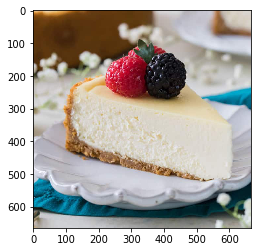

In [22]:
imgplot = plt.imshow(img)

In [30]:
img = load_and_preprocess_image('cheesecake.jpg')
type(img)

tensorflow.python.framework.ops.EagerTensor

In [33]:
img = tf.reshape(img, [1,64,64,3])

In [38]:
predictions = model.predict(img)

In [39]:
results = np.argmax(predictions, axis=1) 

In [41]:
results[0]

17

In [72]:
food_dict = {} 
for key, value in label_to_index.items(): 
   if value in food_dict: 
       food_dict[value].append(key) 
   else: 
       food_dict[value]=[key] 

print(food_dict[results[0]][0])

cheesecake


## Export

In [5]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [6]:
open('resnet50_food101_classifier.tflite', 'wb').write(tflite_model)

94778368

In [7]:
!ls

Food1.ipynb                           weights.data-00001-of-00002
Untitled.ipynb                        weights.index
checkpoint                            weights_attempt_2.data-00000-of-00002
cheesecake.jpg                        weights_attempt_2.data-00001-of-00002
food_classification_old.ipynb         weights_attempt_2.index
food_classifier.ipynb                 weights_attempt_3.data-00000-of-00002
resnet50_food101_classifier.tflite    weights_attempt_3.data-00001-of-00002
saved_models                          weights_attempt_3.index
weights.data-00000-of-00002
